In [1]:
# Copyright 2019 Google LLC
#
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Tests qcore model with po2."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from collections import defaultdict

import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import numpy as np

from qkeras import *

np.random.seed(42)

NB_EPOCH = 200
BATCH_SIZE = 64
VERBOSE = 1
NB_CLASSES = 10
OPTIMIZER = Adam(learning_rate=0.0001)
VALIDATION_SPLIT = 0.1

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train /= 255.0
x_test /= 255.0

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

print(y_train[0:10])

y_train = to_categorical(y_train, NB_CLASSES)
y_test = to_categorical(y_test, NB_CLASSES)


50000 train samples
10000 test samples
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [2]:

x = x_in = Input(x_train.shape[1:], name="input")
x = QActivation("quantized_relu_po2(4,4)", name="acti")(x)
x = QConv2D(
    128, (3, 3),
    strides=1,
    kernel_quantizer=quantized_po2(4, 1, use_stochastic_rounding=True),
    bias_quantizer=quantized_po2(4, 1),    
    name="conv2d_0_m")(x)
x = QActivation("quantized_relu_po2(4,1,use_stochastic_rounding=True)", name="act0_m")(x)
x = tf.keras.layers.MaxPooling2D(2, 2, name="mp_0")(x)
x = QConv2D(
    256, (3, 3),
    strides=1,
    kernel_quantizer=quantized_po2(4, 1, use_stochastic_rounding=True),
    bias_quantizer=quantized_po2(4, 1),   
    name="conv2d_1_m")(x)
x = QActivation("quantized_relu_po2(4,1,use_stochastic_rounding=True)", name="act1_m")(x)
x = tf.keras.layers.MaxPooling2D(2, 2, name="mp_1")(x)
x = QConv2D(
    256, (3, 3),
    strides=1,
    kernel_quantizer=quantized_po2(4, 1, use_stochastic_rounding=True),
    bias_quantizer=quantized_po2(4, 1),   
    name="conv2d_2_m")(x)
x = QActivation("quantized_relu_po2(4,1,use_stochastic_rounding=True)", name="act2_m")(x)
x = tf.keras.layers.MaxPooling2D(2, 2, name="mp_2")(x)
x = tf.keras.layers.Flatten()(x)
x = QDense(
    NB_CLASSES,
    kernel_quantizer=quantized_ulaw(4, 0, 1),
    bias_quantizer=quantized_bits(4, 0, 1),
    name="dense")(
        x)
x = Activation("softmax", name="softmax")(x)

model = Model(inputs=[x_in], outputs=[x])
model.summary()

model.compile(
    loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])

c:\Users\georg\Desktop\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 acti (QActivation)          (None, 32, 32, 3)         0         
                                                                 
 conv2d_0_m (QConv2D)        (None, 30, 30, 128)       3584      
                                                                 
 act0_m (QActivation)        (None, 30, 30, 128)       0         
                                                                 
 mp_0 (MaxPooling2D)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_1_m (QConv2D)        (None, 13, 13, 256)       295168    
                                                                 
 act1_m (QActivation)        (None, 13, 13, 256)       0     

In [3]:


history = model.fit(
    x_train, y_train, batch_size=BATCH_SIZE,
    epochs=NB_EPOCH, initial_epoch=1, verbose=VERBOSE,
    validation_split=VALIDATION_SPLIT)




Epoch 2/200
704/704 [==============================] - 22s 26ms/step - loss: 2.6150 - accuracy: 0.2596 - val_loss: 2.2955 - val_accuracy: 0.3008
Epoch 3/200
704/704 [==============================] - 17s 24ms/step - loss: 2.1468 - accuracy: 0.3316 - val_loss: 2.1347 - val_accuracy: 0.3334
Epoch 4/200
704/704 [==============================] - 17s 24ms/step - loss: 1.9550 - accuracy: 0.3772 - val_loss: 1.9202 - val_accuracy: 0.3890
Epoch 5/200
704/704 [==============================] - 17s 24ms/step - loss: 1.8423 - accuracy: 0.4099 - val_loss: 1.9002 - val_accuracy: 0.4072
Epoch 6/200
704/704 [==============================] - 17s 24ms/step - loss: 1.7329 - accuracy: 0.4389 - val_loss: 1.8014 - val_accuracy: 0.4298
Epoch 7/200
704/704 [==============================] - 17s 25ms/step - loss: 1.6811 - accuracy: 0.4569 - val_loss: 1.6295 - val_accuracy: 0.4716
Epoch 8/200
704/704 [==============================] - 17s 25ms/step - loss: 1.5692 - accuracy: 0.4877 - val_loss: 1.6407 - val_ac

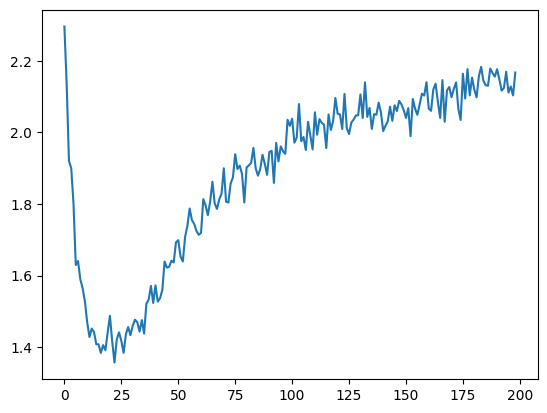

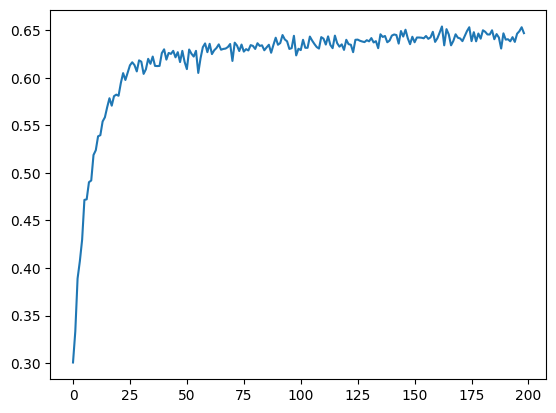

In [5]:
import matplotlib.pyplot as plt


#plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()    

In [13]:
# try to save model
from qkeras.utils import model_save_quantized_weights

model.evaluate(x_test, y_test)


d = model_save_quantized_weights(model, "qmodels/qkeras/qmodel")
d = model_save_quantized_weights(model, "qmodels/qkeras/qmodel.h5")


model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 2.4203 - accuracy: 0.6373
... quantizing model


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'qmodels/qkeras/qmodel.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [12]:
model.load_weights("qmodels/qmodel.h5")
model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 2.4203 - accuracy: 0.6373


[2.4202771186828613, 0.6373000144958496]